## Assessing the quality of features 

### Features of the ongoing research project :
1. This Notebook has the implementation of all the features as described in RAOP Research Paper http://snap.stanford.edu/class/cs224w-2013/projects2013/cs224w-025-final.pdf
2. The dataset is obtained from http://www/kaggle.com and comes from the Random Acts Of Pizza subreddit at http://reddit.com.
3. This dataset comes with 5671 textual requests for pizza from the Reddit community with their outcome (successful/unsuccessful) and meta-data.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import nltk.data
from collections import Counter

In [2]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet as wn
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhjha8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/abhjha8/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abhjha8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [5]:
data_train = pd.read_json('./data/train.json')
data_train['data_type'] = 'train'
y = data_train.pop('requester_received_pizza')
data_train.head(2)

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,...,[],0,1,0,1,None,nickylvst,1317852607,1317849007,train
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,...,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824,train


In [6]:
data_test = pd.read_json('./data/test.json')
data_test['data_type'] = 'test'
data_test.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type
0,N/A,t3_i8iy4,Hey all! It's about 95 degrees here and our ki...,[request] pregger gf 95 degree house and no fo...,42.083866,0.0,57,0,10,0,16,"[AskReddit, COents, Denver, DenverBroncos, Lib...",364,840,j_like,1308963419,1308959819,test
1,N/A,t3_1mfqi0,I didn't know a place like this exists! \n\nI ...,"[Request] Lost my job day after labour day, st...",223.784537,0.0,145,0,36,0,29,"[Android, AskReddit, GrandTheftAutoV, IAmA, Mi...",516,1448,0110110101101100,1379263523,1379259923,test


In [7]:
not_present = []
for i in data_train.columns:
    if i not in data_test.columns:
        not_present.append(i)
data_train.drop(labels=not_present,axis=1,inplace=True)

In [8]:
## Combining the training and testing data
data = pd.concat([data_train,data_test],ignore_index=True)
data_copy = data.copy()
data.shape

(5671, 18)

In [9]:
data.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,0,[],0,0,nickylvst,1317852607,1317849007,train
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,12,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824,train


In [10]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck <L.J.Buitinck@uva.nl>
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

n_samples = 2000
n_features = 1000
n_topics = 20
n_top_words = 20

def applyNMF(data_samples):
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0,min_df=1,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
    nmf = NMF(n_components=n_topics, random_state=1, l1_ratio=.5).fit(tfidf)
    return nmf.transform(tfidf)

In [11]:
topics = applyNMF(data['request_text_edit_aware'])
print(topics.shape)

Extracting tf-idf features for NMF...
Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
(5671, 20)


In [12]:
topics_vec = np.argmax(topics,axis=1)

In [13]:
data['topics'] = topics_vec
data['topics'].head()

0     3
1    19
2     8
3     5
4     1
Name: topics, dtype: int64

## Finding the Success Rate of Important Features

In [14]:
## Finding the nature of the topics generated

imp_topics = Counter(topics_vec).most_common(10)
print(imp_topics)

[(18, 518), (8, 507), (16, 378), (2, 345), (4, 336), (6, 333), (15, 294), (12, 283), (0, 281), (11, 276)]


In [15]:
def find_topic(topic,remove_verbs=True):
    requests = data_copy[data['topics'] == imp_topics[topic][0]]['request_text_edit_aware']
    chain_requests = ''
    for request in requests:
        chain_requests += ('. '+request)
    chain_requests = re.sub('^[a-zA-Z]',' ',chain_requests)
    words = [word for word in chain_requests.split() if word not in stopwords.words("english")]
    if remove_verbs:
        words = [word for word in words if word in nouns]
    return Counter(words).most_common(100)

In [16]:
topic_words = []
for i in range(len(imp_topics)):
    words = find_topic(i)
    words = ' '.join([word[0] for word in words])
    topic_words.append(words)

In [17]:
train = data[data['data_type'] == 'train']
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,0,[],0,0,nickylvst,1317852607,1317849007,train,3
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,12,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824,train,19


In [18]:
train['received'] = y
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,0,[],0,0,nickylvst,1317852607,1317849007,train,3,False
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,12,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824,train,19,False


In [19]:
topic_df = []
for i in range(len(imp_topics)):
    topic_df.append([imp_topics[i][0],topic_words[i],100*float(train[train['topics'] == imp_topics[i][0]]['received'].sum())\
                     /len(train[train['topics'] == imp_topics[i][0]]['received'])])

In [20]:
topic_df = pd.DataFrame(topic_df,columns = ['Topic','Words','Success Rate'])
topic_df

,Topic,Words,Success Rate
0,18,pizza get like money one right need go give mu...,21.983914
1,8,food money get pizza last back little go much ...,25.842697
2,16,get work pizza day like going time back know l...,22.344322
3,2,forward get pizza back money last love one muc...,31.726908
4,4,pizza get like money know one last food right ...,34.274194
5,6,pizza get right use like food money know much ...,21.610169
6,15,pizza tonight get like dinner food love one la...,25.961538
7,12,get pizza last like past food two days know ti...,32.500000
8,0,pizza get know like sob give story one back mo...,18.750000
9,11,pizza get thanks like money time much food one...,25.773196


### Success of Different Topics

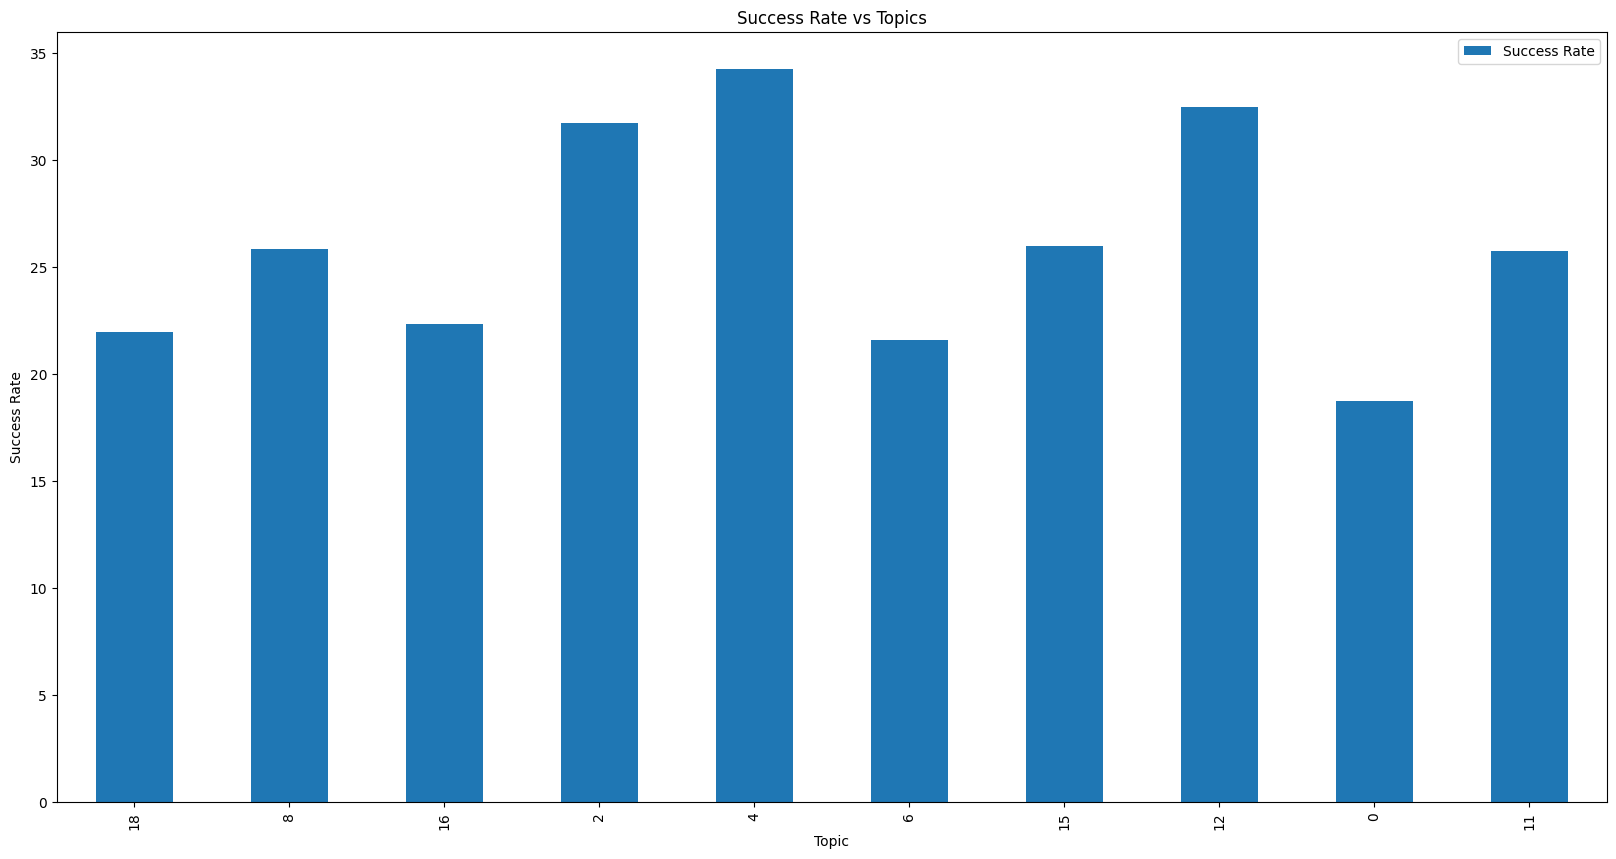

In [21]:
topic_df.plot(kind='bar',y='Success Rate',x='Topic')
plt.xlabel('Topic')
plt.ylabel('Success Rate')
plt.title('Success Rate vs Topics')
plt.show()

### Success correlation with the length of request

In [22]:
train.dropna(inplace=True,axis=0)
train.tail(1)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received
4039,N/A,t3_189pw1,"Like the title says, had to pay an unexpected ...","[Request] USA WA. Unexpected bill, couldn't go...",572.314942,0.0,523,0,20,0,28,"[AskReddit, Drugs, IAmA, LongDistance, Minecra...",3212,8424,Ellebean,1360535063,1360535063,train,14,False


In [23]:
train['request_length'] = [len(x.split()) for x in train['request_text_edit_aware']]
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received,request_length
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,...,[],0,0,nickylvst,1317852607,1317849007,train,3,False,67
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,...,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824,train,19,False,16


In [24]:
length = []
def length_success(topic):    
    max_length = train[train['topics'] == topic]['request_length'].max()
    min_length = train[train['topics'] == topic]['request_length'].min()
    bin_size = (max_length - min_length)/20
    df = train[train['topics'] == topic]
    for i in range(10):
        df_one = df[(df['request_length'] >= min_length) & (df['request_length'] < min_length+bin_size)]
        df_new = df_one[df_one['received'] == True]
        if(len(df_one) == 0):
            df_one = ['a']
        length.append([topic,min_length,min_length+bin_size,float(len(df_new))/len(df_one)])
        min_length = min_length + bin_size

In [25]:
for topic in imp_topics:
    print('Calculating length probabilities for {} topic..'.format(topic[0]))
    length_success(topic[0])

Calculating length probabilities for 18 topic..
Calculating length probabilities for 8 topic..
Calculating length probabilities for 16 topic..
Calculating length probabilities for 2 topic..
Calculating length probabilities for 4 topic..
Calculating length probabilities for 6 topic..
Calculating length probabilities for 15 topic..
Calculating length probabilities for 12 topic..
Calculating length probabilities for 0 topic..
Calculating length probabilities for 11 topic..


In [26]:
df_length = pd.DataFrame(length,columns=['Topic','Lower Bound','Upper Bound','Probability Success'])
df_length.head(5)

,Topic,Lower Bound,Upper Bound,Probability Success
0,18,3.00,23.95,0.123288
1,18,23.95,44.90,0.193548
2,18,44.90,65.85,0.223881
3,18,65.85,86.80,0.214286
4,18,86.80,107.75,0.200000


In [27]:
df_length.to_csv('LengthCorrelation.csv',sep=',',columns=df_length.columns)

In [28]:
topic_points = []
for topic in imp_topics:
    points = []
    df_new = df_length[df_length['Topic'] == topic[0]]
    for i in range(8):    
        points.append(((df_new.iloc[i,1] + df_new.iloc[i,2]/2),df_new.iloc[i,3]))
    topic_points.append(points)

### Length and Topic relation in view of the successful requests

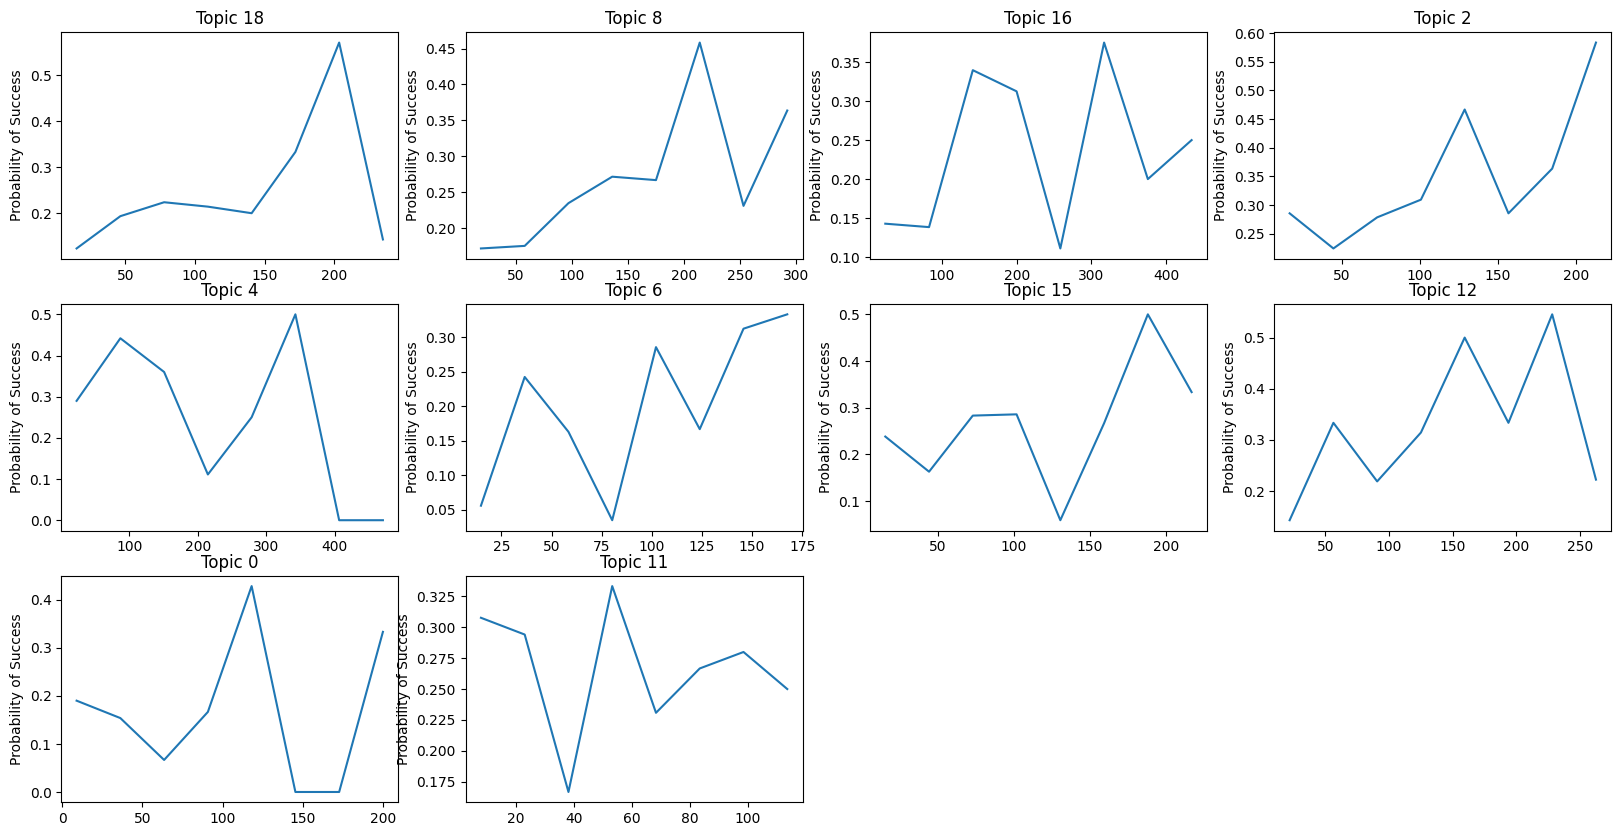

In [29]:
i = 1
for points in topic_points:
    plt.subplot(3,4,i)
    plt.plot([point[0] for point in points],[point[1] for point in points])
    plt.ylabel('Probability of Success')
    plt.title('Topic {}'.format(imp_topics[i-1][0]))
    i += 1
    if i > 10:
        i = 1
plt.show()

### Finding 'Evidentiality' in each of the request

In [30]:
import re
regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [31]:
evidentiality,i = np.ones((len(train['request_text_edit_aware']))),0
for request in train["request_text_edit_aware"]:
    url = re.findall(regex,request)
    if len(url) <= 0:
        evidentiality[i] = 0
    i += 1

In [32]:
train['evidentiality'] = evidentiality
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received,request_length,evidentiality
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,...,0,0,nickylvst,1317852607,1317849007,train,3,False,67,0.0
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,...,34,116,fohacidal,1332652424,1332648824,train,19,False,16,0.0


In [33]:
## How evidentiality affects the success rate
total = train[train['evidentiality'] == 1].received
success = len(total[total == True])
print('Percentage of successful requests with evidence: {}%'.format(round(float(success)*100/len(total),3)))

Percentage of successful requests with evidence: 35.192%


In [34]:
total = train[train['evidentiality'] == 0].received
success = len(total[total == True])
print('Percentage of successful requests without evidence: {}%'.format(round(float(success)*100/len(total),3)))

Percentage of successful requests without evidence: 23.794%


### Relation of Evidentiality with Success of a request

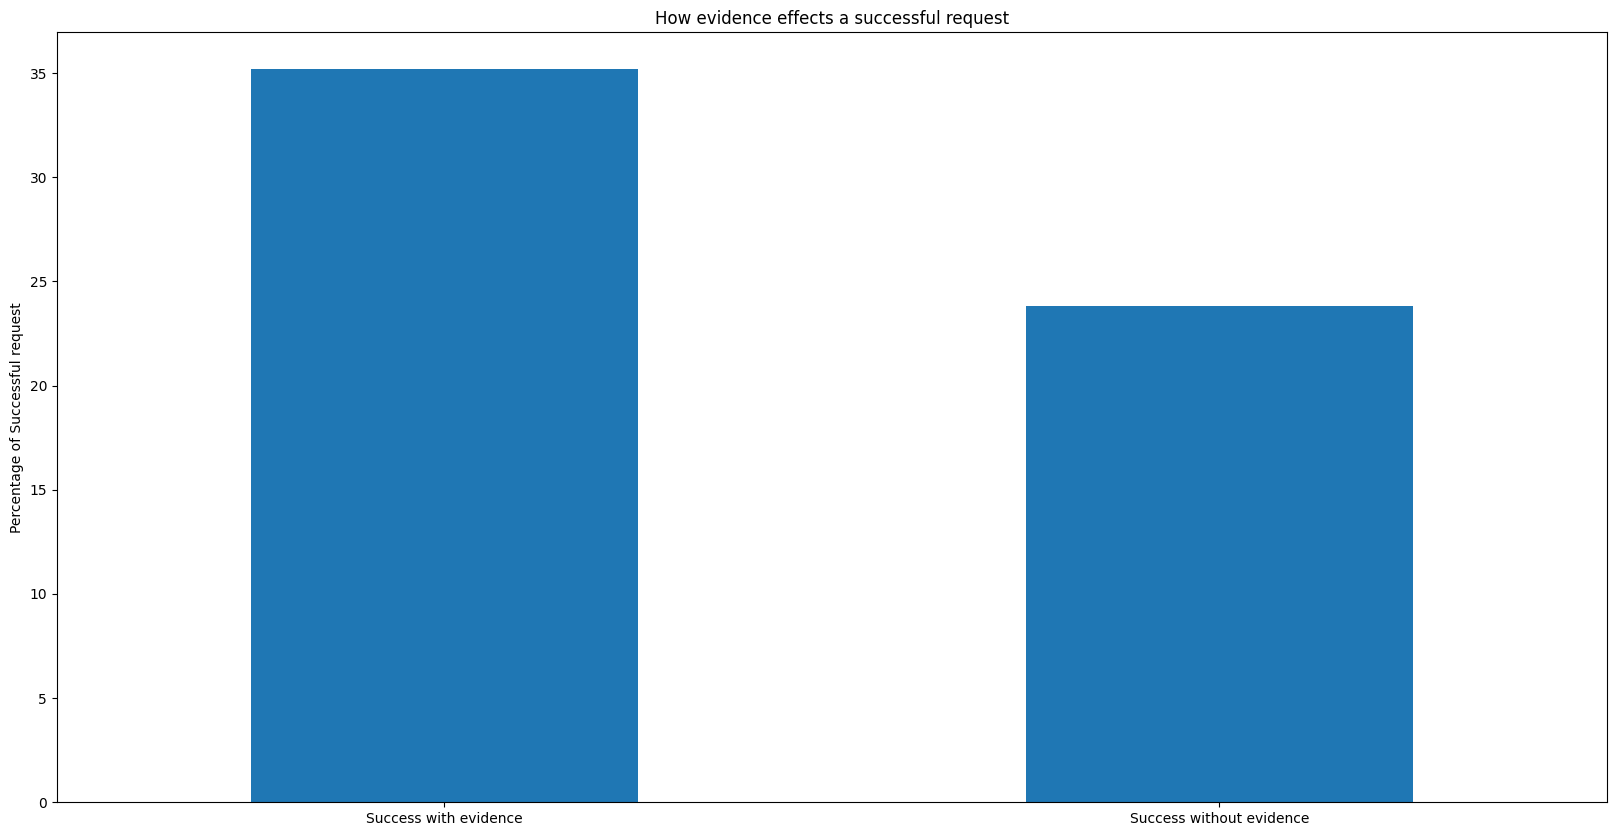

In [35]:
evidence_relation = pd.Series({'Success with evidence':35.192,'Success without evidence':23.794})
evidence_relation.to_csv('evidenceRelation.csv',sep=',')
evidence_relation.plot(kind='bar',rot=0)
plt.ylabel('Percentage of Successful request')
plt.title('How evidence effects a successful request')
plt.show()

### Finding reciprocity in the request

In [36]:
reciprocity,i = np.zeros((len(train['request_text_edit_aware']),)),0
regex = 'return the favor|pay it forward|pay it back'
for request in train['request_text_edit_aware']:
    match = re.search(regex,request)
    if match:
        reciprocity[i] = 1
    i += 1

In [37]:
train['reciprocity'] = reciprocity
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received,request_length,evidentiality,reciprocity
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,...,0,nickylvst,1317852607,1317849007,train,3,False,67,0.0,0.0
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,...,116,fohacidal,1332652424,1332648824,train,19,False,16,0.0,0.0


In [38]:
## Finding percentage of successful request with reciprocity and without it
total = train[train['reciprocity'] == 1].received
success = len(total[total == True])
print('Percentage of successful requests with reciprocity: {}%'.format(round(float(success)*100/len(total),3)))

Percentage of successful requests with reciprocity: 30.058%


In [39]:
total = train[train['reciprocity'] == 0].received
success = len(total[total == True])
print('Percentage of successful requests with reciprocity: {}%'.format(round(float(success)*100/len(total),3)))

Percentage of successful requests with reciprocity: 23.8%


### Relation of Reciprocity with Successful request

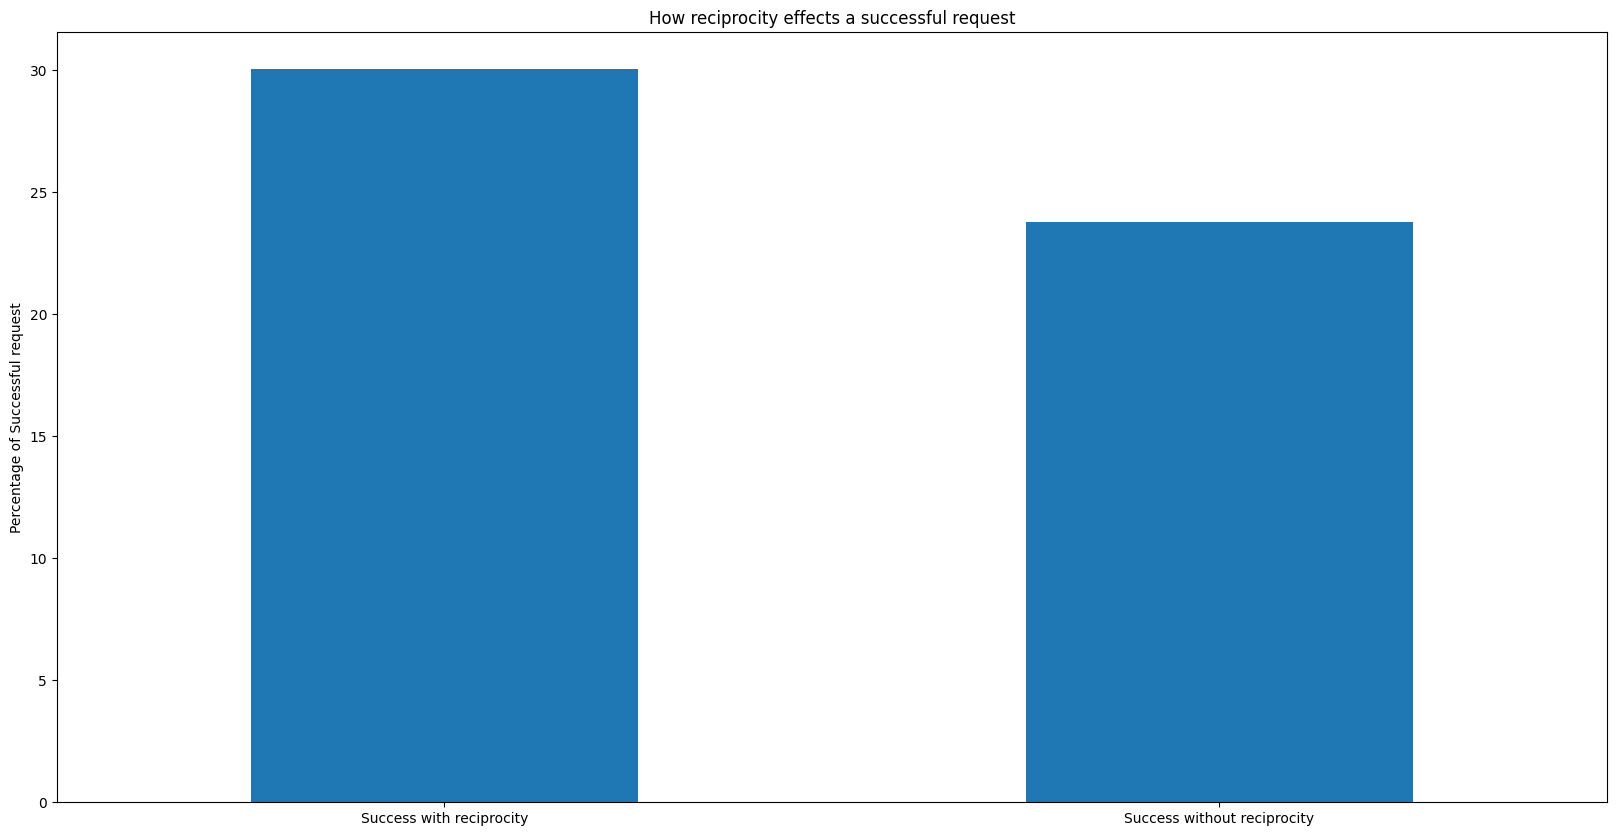

In [40]:
reciprocity_relation = pd.Series({'Success with reciprocity':30.058,'Success without reciprocity':23.8})
reciprocity_relation.to_csv('reciprocity_relation.csv',sep=',')
reciprocity_relation.plot(kind='bar',rot=0)
plt.ylabel('Percentage of Successful request')
plt.title('How reciprocity effects a successful request')
plt.show()

## Introducing new features in the dataset

### Narratives

In [41]:
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received,request_length,evidentiality,reciprocity
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,...,0,nickylvst,1317852607,1317849007,train,3,False,67,0.0,0.0
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,...,116,fohacidal,1332652424,1332648824,train,19,False,16,0.0,0.0


In [42]:
narrative = {'Money': 'money now broke week until time last \
day when today tonight paid next first night after tomorrow \
month while account before long Friday rent buy bank still \
bills bills ago cash due due soon past never paycheck check \
spent years poor till yesterday morning dollars financial \
hour bill evening credit budget loan bucks deposit dollar \
current payed'.split(),'Job':'work job paycheck unemployment\
interview fired employment hired hire'.split(),'Student':'college\
student school roommate studying university finals semester class\
study project dorm tuition'.split(),'Family':'family mom wife parents\
mother hus- band dad son daughter father parent mum'.split(),'Craving':'friend \
girlfriend craving birthday boyfriend celebrate party game games movie\
date drunk beer celebrating invited drinks crave wasted invite'.split()}

In [43]:
request_narrative = []
narration = []
for request in train['request_text_edit_aware']:
    word_count = {'Money':0,'Job':0,'Student':0,'Family':0,'Craving':0}
    n = 0
    for word in request.split():
        for lexicon in narrative:
            if word in narrative[lexicon]:
                word_count[lexicon] += 1
    for lexicon in word_count:
        n += word_count[lexicon]
    request_narrative.append(word_count)
    try:
        narration.append(float(n)/len(request.split()))
    except:
        narration.append(0)

In [44]:
train['narrative'] = narration

In [45]:
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

In [46]:
## Warning : TAKES A LONG TIME TO RUN
## DON'T RUN UNTIL REQUIRED
text_documents,i = [],2501
for text in train:
    i += 1
    parsed_sents = {}
    try:
        parsed_sents['text'] = text
        parsed_sents['sentences'] = [sents for sents in np.asarray(tokenizer.tokenize(text)) if len(sents.split()) > 1]
        temp = []
        for sentence in parsed_sents['sentences']:
            try:
                temp.append(dep_parse(sentence))
            except:
                pass
        parsed_sents['parses'] = temp
    except:
        print(text)
        break
    text_documents.append(parsed_sents)
    print('{} requests parsed...'.format(i))
    if i%100 == 0:
        %store text_documents >> test_documents_new.py

2502 requests parsed...
2503 requests parsed...
2504 requests parsed...
2505 requests parsed...
2506 requests parsed...
2507 requests parsed...
2508 requests parsed...
2509 requests parsed...
2510 requests parsed...
2511 requests parsed...
2512 requests parsed...
2513 requests parsed...
2514 requests parsed...
2515 requests parsed...
2516 requests parsed...
2517 requests parsed...
2518 requests parsed...
2519 requests parsed...
2520 requests parsed...
2521 requests parsed...
2522 requests parsed...
2523 requests parsed...
2524 requests parsed...
2525 requests parsed...


### Finding Redundancy in requests using Cosine Similarity

In [47]:
def statistical_sim(sent1, sent2):
    '''
    Statistical similarity between sentences
    based on the cosine method
    Returns: float (the cosine similarity b/w sent1 and sent2)
    '''
    sent_token1 = Counter(sent1)
    sent_token2 = Counter(sent2)

    intxn = set(sent_token1) & set(sent_token2)
    numerator = sum([sent_token1[x] * sent_token2[x] for x in intxn])

    mod1 = sum([sent_token1[x]**2 for x in sent_token1.keys()])
    mod2 = sum([sent_token2[x]**2 for x in sent_token2.keys()])
    denominator = sqrt(mod1)*sqrt(mod2)

    if not denominator:
        return 0.0

    return float(numerator)/denominator

In [48]:
## Sanity check for statistical similarity
sent1 = 'Hello my name is Abhinav Kumar Jha'
sent2 = 'Hello my name is Abhinav Kumar Jha'
statistical_sim(sent1,sent2)

1.0000000000000002

In [49]:
## Warning : Takes a long time to RUN
## Do not RUN until required
i = 0
similarity = []
for request1 in data_train['request_text_edit_aware']:
    cosine_sim = []
    for request2 in data_train['request_text_edit_aware']:
        if request1 != request2:
            cosine_sim.append(statistical_sim(request1,request2))
    similarity.append([np.argmax(np.asarray(cosine_sim)),np.max(np.asarray(cosine_sim))])
    i += 1

In [50]:
train['similarity'] = similarity

### Including the politeness feature

In [52]:
# # to be created by self
# politeness_data = pd.read_csv('./data/politeness_one.csv',index_col=0)
# part_two = pd.read_csv('./data/politeness_two.csv',index_col=0)

In [53]:
# ## One data is missing... So appending missing data
# politeness_data = politeness_data.append({'text':data_train.iloc[2500,2],'polite':0.5,'impolite':0.5},ignore_index=True)

In [54]:
# ## Sanity Check for the size of dataset
# print(politeness_data.shape[0] + part_two.shape[0] == train.shape[0])

In [55]:
# ## Adding the politeness data into 'master' dataframe
# politeness_data = politeness_data.append(part_two,ignore_index=True)
# train['polite'] = politeness_data['polite']
# train['impolite'] = politeness_data['impolite']

### Creating the target .json file

In [56]:
train.head(2)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,unix_timestamp_of_request,unix_timestamp_of_request_utc,data_type,topics,received,request_length,evidentiality,reciprocity,narrative,similarity
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,0.0,0,0,0,0,...,1317852607,1317849007,train,3,False,67,0.0,0.0,0.044776,"[11, 0.9920912136931981]"
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,0.0,0,0,15,0,...,1332652424,1332648824,train,19,False,16,0.0,0.0,0.375000,"[1971, 0.9757849287676627]"


In [57]:
train.to_json('./data/trainingData.json',orient='columns')

In [58]:
if train.isnull().values.any() == False:
    print("Data preparation complete")

Data preparation complete
